In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams.update({'font.size': 14})
import os
import pickle
import seaborn as sns
import json
import random


from utils_Semantic_Phonetic_Clustering import *
from language_models import *

/home/15171531/miniconda3/envs/analysis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1>Set seeds</h1>

In [10]:
# Set the seed value
SEED = 42

# Set seed for Python's built-in random module
random.seed(SEED)

# Set seed for NumPy
np.random.seed(SEED)

# Set seed for PyTorch 
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

<h1>Global variables for what you want to run</h1>

In [ ]:
# set to True if big objects (dicts/ dfs) should be deleted after full use to save memory (recommended)
MEMORY_EFFICIENT = True

# set to True/ False depending on type of analysis
LOAD_FULL_DF = True

LOAD_ABS_CONC_DF = True

LOAD_MALD_AND_PRONOUNCIATION = True

COMPUTE_SEMANTIC_CATEGORIES = True

COMPUTE_PHONETIC_GROUPS = True

COMPUTE_PHONETIC_SIMILARITY = True

COMPUTE_BASELINES = False  # not used for these experiments

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using: {DEVICE}')

Using: cpu


In [6]:
# create dir for saving results and data
os.makedirs('exp1', exist_ok=True)

<h1>Load the data</h1>

In [ ]:
# TODO: set paths here

embedding_path = 'embeddings/' 

w2v2_embedding_path = 'embeddings/wav2vec2/MALD/w2v2_MALD.pkl' 

fast_vgs_plus_path = 'embeddings/fast_vgs/MALD/fast_vgs_plus_MALD.pkl'

MALD_path = 'data/audio/' 

data_path = 'exp1_data/'

vg_bert_ckp_path = 'vg_bert_best_model.pth' 

figure_path = 'exp1/' 


<h4>Load the embeddings for the different models</h4>

In [30]:
# for creating the dataframe
if LOAD_FULL_DF:
    df = pd.read_pickle(data_path + 'FULL_DF.pkl')
else:
    # load dataframes
    with open(w2v2_embedding_path, "rb") as f:
        w2v2 = pickle.load(f)
    with open(fast_vgs_plus_path, "rb") as f:
        fast_vgs_plus = pickle.load(f)

    print(f'dataframes with embeddings for w2v2 and fast_vgs_plus loaded')

    # fix file_path column to contain words only instead of full path
    w2v2["file_path"] = w2v2["file_path"].apply(lambda x: x.split("/")[-1].split(".")[0].lower())
    fast_vgs_plus["file_path"] = fast_vgs_plus["file_path"].apply(lambda x: x.split("/")[-1].split(".")[0].lower())

    # merge the two dataframes
    df = pd.merge(w2v2, fast_vgs_plus, on="file_path", how="inner")
    df = df.rename(columns={"file_path": "words"})

    # convert torch tensors to arrays
    df = convert_embeddings_to_arrays(df)

    # load glove embeddings
    glove_embeddings_dict = load_glove_embeddings(data_path + 'glove.6B.300d.txt')

    print(f'glove embeddings loaded')

    # add glove embeddings to dataframe
    df['glove_embeddings'] = df['words'].apply(
        lambda word: glove_embeddings_dict[word] 
        if word in glove_embeddings_dict else None
    )
    if MEMORY_EFFICIENT:
        del glove_embeddings_dict
    
    print(f'glove embeddings added to dict')

    # load (visually grounded) language embeddings
    reg_bert = load_pretrained_bert_model(pretr_type='bert-base-uncased', output_hidden=True, device=DEVICE)
    vg_bert = load_pretrained_vg_bert_model(checkpoint_path=vg_bert_ckp_path, device=DEVICE, output_hidden=True)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    print(f'loaded BERT and VGBERT')
    df['reg_bert_embeddings'] = None
    df['vg_bert_embeddings'] = None
    # add language embeddings to dataframe
    for i, row in df.iterrows():
        if i % 100 == 0:
            print(f'Processing row {i}...')
        reg_bert_embds = get_layerwise_embeddings(reg_bert, tokenizer, row['words'], device=DEVICE)
        vg_bert_embds = get_layerwise_embeddings(vg_bert, tokenizer, row['words'], device=DEVICE)
        df.at[i, 'reg_bert_embeddings'] = reg_bert_embds
        df.at[i, 'vg_bert_embeddings'] = vg_bert_embds

    print(f'added BERT and VGBERT embeddings to df')
    
    df.to_pickle(data_path + 'FULL_DF.pkl')
    print(f'saved dt at {data_path}/FULL_DF.pkl')

<h4>Load concrete vs abstract dataframe</h4>

In [42]:
if LOAD_ABS_CONC_DF:
    conc_abs_df = pd.read_csv(data_path + 'Abstract_vs_Concrete.csv', delimiter=';')
    conc_abs_df['Conc.M'] = conc_abs_df['Conc.M'].str.replace(',', '.', regex=False)
    conc_abs_df['Conc.M'] = pd.to_numeric(conc_abs_df['Conc.M'], errors='coerce')
    print(conc_abs_df['Conc.M'].mean())
    conc_abs_df['Word'] = conc_abs_df['Word'].astype(str)
    conc_abs_df['Word'] = conc_abs_df['Word'].str.lower()
    # print last couple of words
    print(conc_abs_df['Word'][-5:])

3.0362669570005507
39949    zebra crossing
39950    zero tolerance
39951          zip code
39952           zoom in
39953         zoom lens
Name: Word, dtype: object


<h4>Load list of MALD recordings and pronounciation dict</h4>

In [12]:
if LOAD_MALD_AND_PRONOUNCIATION:
    wav_list = os.listdir(MALD_path) #os.listdir(MALD_path + 'MALD1_rw')
    print(wav_list[:11])
    # filter to get only words
    wav_list = [file.lower()[:-4] for file in wav_list if file.endswith('.wav')]
    print(wav_list[:11])
    len(wav_list)
    pronunc_df = pd.read_csv(MALD_path + 'MALD1_ItemData.txt', sep="\t")
    pronunc_df = pronunc_df[pronunc_df['IsWord'] == np.True_]
    pronunc_df.reset_index()
    pronunc_df = pronunc_df[['Item', 'WAV', 'Pronunciation']]
    print(pronunc_df.shape)

['ENERVATION.wav', 'CARTRIDGES.wav', 'EMBASSIES.wav', 'SENSATION.wav', 'HISPANIC.wav', 'MOLESKIN.wav', 'REVERSED.wav', 'RIVERBANKS.wav', 'HARDTACK.wav', 'SPECKS.wav', 'OUTLINING.wav']
['enervation', 'cartridges', 'embassies', 'sensation', 'hispanic', 'moleskin', 'reversed', 'riverbanks', 'hardtack', 'specks', 'outlining']
(26793, 3)


<h4>Compute baselines (not done in for this experiment)</h4>

In [ ]:
if COMPUTE_BASELINES:
    if os.path.exists(data_path + 'baselines.json'):
        with open(data_path + 'baselines.json', 'r') as json_file:
            baselines = json.load(json_file)
        print('baselines loaded')
    else:
        # Initialize containers for embeddings
        embeddings_dict = {
            "levenshtein": [],
            "glove": [],
            "w2v2": [[] for _ in range(12)],
            "fast_vgs_plus": [[] for _ in range(12)],
            "reg_bert": [[] for _ in range(12)],
            "vg_bert": [[] for _ in range(12)]
        }

        # Extract embeddings
        for _, row in df.iterrows():
            if row['glove_embeddings'] is not None:
                embeddings_dict["glove"].append(row['glove_embeddings'])
            for layer_idx in range(12):
                layer_key = f"layer_{layer_idx}"
                embeddings_dict["w2v2"][layer_idx].append(row['w2v2_embeddings'][layer_key])
                embeddings_dict["fast_vgs_plus"][layer_idx].append(row['fast_vgs_plus_embeddings'][layer_key])
                embeddings_dict["reg_bert"][layer_idx].append(row['reg_bert_embeddings'][layer_key])
                embeddings_dict["vg_bert"][layer_idx].append(row['vg_bert_embeddings'][layer_key])

        # Compute baselines
        baselines = {
            "levenshtein": compute_phonetic_baseline(df['words'].values, pronunc_df, num_runs=2),
            "glove": compute_baseline(embeddings_dict["glove"], num_shuffles=2),
            "w2v2": [compute_baseline(layer, num_shuffles=2) for layer in embeddings_dict["w2v2"]],
            "fast_vgs_plus": [compute_baseline(layer, num_shuffles=2) for layer in embeddings_dict["fast_vgs_plus"]],
            "reg_bert": [compute_baseline(layer, num_shuffles=2) for layer in embeddings_dict["reg_bert"]],
            "vg_bert": [compute_baseline(layer, num_shuffles=2) for layer in embeddings_dict["vg_bert"]],
        }

        if MEMORY_EFFICIENT:
            del embeddings_dict

        with open(data_path + 'baselines.json', 'w') as json_file:
            json.dump(baselines, json_file)

        print(f'Saved baselines in {data_path}baselines.json')
    print(baselines)

<h2>Semantic Clustering</h2>

In [ ]:
if COMPUTE_SEMANTIC_CATEGORIES:
    assert LOAD_MALD_AND_PRONOUNCIATION, 'Need MALD data: set LOAD_MALD_AND_PRONOUNCIATION to True'
    assert LOAD_ABS_CONC_DF, 'Need Concrete_Abstract_Dataframe: set LOAD_ABS_CONC_DF to True'

    sem_categories = {}

    percentile = 25

    # CONCRTETE CATEGORIES
    print(f'###########################')
    print(f'### CONCRETE CATEGORIES ###')
    print(f'###########################')
    print('#############')
    print(f'BUILDING MATERIALS')
    building_materials = [
        "wood", "steel", "brick", "concrete", "glass", 
        "stone", "clay", "mortar", "plaster", 
        "tile", "marble", "granite", "aluminum", 
        "asphalt", "cement",  "copper", 
        "bamboo", "insulation", "carbon fiber", "concrete block", "reinforcement steel"
    ]
    building_material_words = get_matches(building_materials, wav_list)
    building_material_words = get_representative_words(building_material_words, df, percentile=percentile)
    building_material_scores = get_wordlist_meta_data(building_material_words, conc_abs_df, pronunc_df)
    sem_categories['building_materials'] = {
    'words': building_material_words,
    'scores': building_material_scores
    }
    print(f'number of words: {len(building_material_words)}')
    print(building_material_words)
    print('#############')
    print()

    print('#############')
    print(f'VEHICLES')
    vehicles = [
    "car", "bus", "truck", "van", "ambulance", 
    "firetruck", "taxi", "minivan", "jeep", "motorcycle"
    "motorhome", "wagon", "limousine", 
    "pickup truck", "cargo truck", "cement mixer", "streetcar", 
    "tank", "go-kart", "dune buggy", 
    "monorail", "funicular"
    ]
    vehicle_words = get_matches(vehicles, wav_list)
    vehicle_words = get_representative_words(vehicle_words, df, percentile=percentile)
    vehicle_scores = get_wordlist_meta_data(vehicle_words, conc_abs_df, pronunc_df)
    sem_categories['vehicles'] = {
    'words': vehicle_words,
    'scores': vehicle_scores
    }
    print(f'number of words: {len(vehicle_words)}')
    print(vehicle_words)
    print('#############')
    print()

    print('#############')
    print(f'MUSICAL INSTRUMENTS')
    musical_instruments = [
    "piano", "guitar", "violin", "flute", 
    "saxophone", "trumpet", "clarinet", "cello", "harp", 
    "accordion","trombone", "mandolin", "banjo", "oboe", 
    "marimba", "keyboard", "organ", "xylophone", "ukulele", "lute", 
    "fiddle", "didgeridoo", "sitar", "tabla", "bagpipes"
    ]
    musical_instrument_words = get_matches(musical_instruments, wav_list)
    musical_instrument_words = get_representative_words(musical_instrument_words, df, percentile=percentile)
    musical_instrument_scores = get_wordlist_meta_data(musical_instrument_words, conc_abs_df, pronunc_df)
    sem_categories['musical_instruments'] = {
    'words': musical_instrument_words,
    'scores': musical_instrument_scores
    }
    print(f'number of words: {len(musical_instrument_words)}')
    print(musical_instrument_words)
    print('#############')
    print()

    print('#############')
    print(f'ORGANS')
    organs = [
    "brain", "heart", "lungs", "liver", "kidneys", 
    "stomach", "intestines", "bladder", "pancreas", "spleen", 
    "gallbladder", "esophagus", "larynx", "pharynx", 
    "diaphragm", "colon", "rectum", "anus",  "gallbladder", 
    "salivary glands", "sweat glands", "lymph nodes", "bone marrow", "thymus", "appendix", 
    "urinary bladder", "ovaries", "testes"
    ]
    organ_words = get_matches(organs, wav_list)
    organ_words = get_representative_words(organ_words, df, percentile=percentile)
    organ_scores = get_wordlist_meta_data(organ_words, conc_abs_df, pronunc_df)
    sem_categories['organs'] = {
    'words': organ_words,
    'scores': organ_scores
    }
    print(f'number of words: {len(organ_words)}')
    print(organ_words)
    print('#############')
    print()

    print('#############')
    print(f'CLOTHING')
    clothing = [
    "shirt", "pants", "jacket", "dress", "hat", 
    "scarf", "gloves", "shoes", "socks", "coat", 
    "sweater", "suit", "tie", 
    "blouse", "t-shirt", "hoodie", "jeans", 
    "leggings", "boots", "sandals", "slippers", "bikini", 
    "tank top", "vest", "pajamas", "bathrobe", 
    "sweatpants", "sweatshirt", "poncho", "parka", "puffer jacket", 
    "mankini", "breeches", "beret", "beanie", "sunhat", 
    "cummerbund", "clogs", "flip-flops", "raincoat", "windbreaker"
    ]
    clothing_words = get_matches(clothing, wav_list)
    clothing_words = get_representative_words(clothing_words, df, percentile=percentile)
    clothing_scores = get_wordlist_meta_data(clothing_words, conc_abs_df, pronunc_df)
    sem_categories['clothing'] = {
    'words': clothing_words,
    'scores': clothing_scores
    }
    print(f'number of words: {len(clothing_words)}')
    print(clothing_words)
    print('#############')
    print()

    print('#############')
    print(f'VEGETABLES')
    vegetables = [
    "carrot", "potato", "onion", "tomato", "spinach", 
    "cucumber", "lettuce", "garlic", "broccoli", "cabbage", 
    "peas", "cauliflower", "zucchini", "pumpkin", "beet", 
    "eggplant", "asparagus", "green beans", "radish", "sweet potato", 
    "corn", "kale", "avocado", "celery", "brussels sprouts", "leek",
    "artichoke", "chard", "parsnip", "fennel", "rutabaga", 
    "okra", "scallions", "shallot", "turnip", "watercress",
    "chili pepper", "butternut squash", "yams", "collard greens", 
    "daikon", "arugula", "endive", "bok choy", "jicama"
    ]
    vegetable_words = get_matches(vegetables, wav_list)
    vegetable_words = get_representative_words(vegetable_words, df, percentile=percentile)
    vegetable_scores = get_wordlist_meta_data(vegetable_words, conc_abs_df, pronunc_df)
    sem_categories['vegetables'] = {
    'words': vegetable_words,
    'scores': vegetable_scores
    }
    print(f'number of words: {len(vegetable_words)}')
    print(vegetable_words)
    print('#############')
    print()

    # ABSTRACT CATEGORIES
    print(f'###########################')
    print(f'### ABSTRACT CATEGORIES ###')
    print(f'###########################')

    print('#############')
    print(f'EMOTIONS')
    emotions = ['joy', 'happiness', 'contentment', 'gratitude', 'pride', 
    'love', 'affection', 'admiration', 'excitement', 'hope', 
    'optimism', 'euphoria', 'relief', 'compassion', 'trust']
    emotion_words = get_matches(emotions, wav_list)
    emotion_words = get_representative_words(emotion_words, df, percentile=percentile)
    emotion_scores = get_wordlist_meta_data(emotion_words, conc_abs_df, pronunc_df)
    sem_categories['emotions'] = {
    'words': emotion_words,
    'scores': emotion_scores
    }
    print(f'number of words: {len(emotion_words)}')
    print(emotion_words)
    print('#############')
    print()


    print('#############')
    print(f'FINANCIAL TERMS')
    financial_terms = ['income', 'revenue', 'economy', 'deficit', 'surplus',
                       'recession', 'budget', 'financial', 'savings', 'investment',
                       'assets', 'liabilities', 'capital', 'expenditure', 'profit',
                       'cashflow', 'valuation', 'subsidy', 'debt', 'taxation']
    financial_term_words = get_matches(financial_terms, wav_list)
    financial_term_words = get_representative_words(financial_term_words, df, percentile=percentile)
    financial_term_scores = get_wordlist_meta_data(financial_term_words, conc_abs_df, pronunc_df)
    sem_categories['financial_terms'] = {
    'words': financial_term_words,
    'scores': financial_term_scores
    }
    print(f'number of words: {len(financial_term_words)}')
    print(financial_term_words)
    print('#############')
    print()

    print('#############')
    print(f'Law-related terms')
    law_terms = ['obligation', 'rights', 'freedom', 'equality', 
    'justice', 'fairness', 'legality', 'accountability', 
    'sanction', 'remedy', 'discrimination']

    law_words = get_matches(law_terms, wav_list)
    law_words = get_representative_words(law_words, df, percentile=percentile)
    law_scores = get_wordlist_meta_data(law_words, conc_abs_df, pronunc_df)
    sem_categories['law_words'] = {
    'words': law_words,
    'scores': law_scores
    }
    print(f'number of words: {len(law_words)}')
    print(law_words)
    print('#############')
    print()

    # print('#############')
    # print(f'PHILOSOPHICAL IDEAS')
    # philosophical_ideas = [
    # "ontology", "epistemology", "agnosticism", "idealism", 
    # "pragmatism", "relativism", "rationalism", "empiricism", "conceptualism", 
    # "phenomenology", "dualism", "determinism", "existentialism", "materialism", 
    # "objectivism", "absolutism", "imperative", "libertarianism",
    # "skepticism", "humanism", "structuralism", "postmodernism", 
    # "nihilism", "theism", "pantheism", "monism", "solipsism", 
    # "intellectualism", "anarchism", "utilitarianism", "deontologism", 
    # "egalitarianism", "altruism", "transcendentalism", "hedonism", 
    # "stoicism", "theocentrism", "reductionism", "historicism", "behaviorism",
    # "authenticity", "absurdism", "liberalism", "communitarianism", "individualism", 
    # "egalitarianism", "deontological ethics", "virtue ethics", "moral relativism",
    # "free will", "social contract", "utilitarian ethics", "teleology", 
    # "phenomenalism", "idealistic realism", "pluralism", "consequentialism", 
    # "nominalism", "anti-realism", "compatibilism", "existential nihilism", 
    # "natural law", "pragmatic realism", "moral absolutism", "anti-authoritarianism", 
    # "human dignity", "post-structuralism", "critical theory", "new materialism"
    # ]
    # philosophical_idea_words = get_matches(philosophical_ideas, wav_list)
    # philosophical_idea_words = get_representative_words(philosophical_idea_words, df, percentile=percentile)
    # philosophical_idea_scores = get_wordlist_meta_data(philosophical_idea_words, conc_abs_df, pronunc_df)
    # sem_categories['philosphical_ideas'] = {
    # 'words': philosophical_idea_words,
    # 'scores': philosophical_idea_scores
    # }
    # print(f'number of words: {len(philosophical_idea_words)}')
    # print(philosophical_idea_words)
    # print('#############')
    # print()

    # print('#############')
    # print(f'SCIENCES')
    # sciences = [
    # "biology", "chemistry", "physics", "mathematics", 
    # "astronomy", "sociology", "anthropology",
    # "genetics", "biochemistry", "neuroscience", "philosophy of science", 
    # "engineering", "computer science", "economics", "hydrology",
    # "botany", "genomics", "biophysics", "marine biology", 
    # "astronomical physics", "quantum mechanics", "climatology", "materials science", 
    # "astrophysics", "theoretical physics", "thermodynamics", "organic chemistry", 
    # "inorganic chemistry", "nuclear physics", "applied mathematics", 
    # "statistics", "geophysics", "geochemistry", 
    # "bioinformatics", "geodesy", "cartography", "veterinary science", "forensic science",
    # "neurochemistry", "toxicology", "phytochemistry", "paleontology", "agronomy", "linguistics",
    # "optics", "ethics", "pharmacogenomics"
    # ]
    # sciences_words = get_matches(sciences, wav_list)
    # sciences_words = get_representative_words(sciences_words, df, percentile=percentile)
    # sciences_scores = get_wordlist_meta_data(sciences_words, conc_abs_df, pronunc_df)
    # sem_categories['sciences'] = {
    # 'words': sciences_words,
    # 'scores': sciences_scores
    # }
    # print(f'number of words: {len(sciences_words)}')
    # print(sciences_words)
    # print('#############')
    # print()

    # print('#############')
    # print(f'Cognitve states')
    # cognitive_terms = [
    # 'awareness',
    # 'attention',
    # 'concentration',
    # 'memory',
    # 'perception',
    # 'understanding',
    # 'comprehension',
    # 'insight',
    # 'belief',
    # 'certainty',
    # 'doubt',
    # 'knowledge',
    # 'learning',
    # 'reasoning',
    # 'intuition',
    # 'judgment',
    # 'reflection',
    # 'creativity',
    # 'imagination',
    # 'curiosity']
    # cognitive_words = get_matches(cognitive_terms, wav_list)
    # cognitive_words = get_representative_words(cognitive_words, df, percentile=percentile)
    # cognitive_scores = get_wordlist_meta_data(cognitive_words, conc_abs_df, pronunc_df)
    # sem_categories['cognitive_terms'] = {
    # 'words': cognitive_words,
    # 'scores': cognitive_scores
    # }
    # print(f'number of words: {len(cognitive_words)}')
    # print(cognitive_words)
    # print('#############')
    # print()

    # print('#############')
    # print(f'FAMILY TERMS')
    # family_terms = [
    # 'mother', 'father', 'sister', 'brother', 'daughter', 'son', 
    # 'grandmother', 'grandfather', 'aunt', 'uncle', 'niece', 'nephew', 
    # 'cousin', 'husband', 'wife', 'stepmother', 'stepfather', 'stepsister', 
    # 'stepbrother', 'half-sister', 'half-brother', 'in-laws', 'parent-in-law', 
    # 'brother-in-law', 'sister-in-law', 'godmother', 'godfather'
    # ]   
    # family_words = get_matches(family_terms, wav_list)
    # family_words = get_representative_words(family_words, df, percentile=percentile)
    # family_scores = get_wordlist_meta_data(family_words, conc_abs_df, pronunc_df)
    # sem_categories['family'] = {
    # 'words': family_words,
    # 'scores': family_scores
    # }
    # print(f'number of words: {len(family_words)}')
    # print(family_words)
    # print('#############')
    # print()

    # sort the word dict by the concreteness scores of the categories
    sem_categories = dict(sorted(sem_categories.items(), key=lambda item: item[1]['scores']['avg_concreteness_score'], reverse=True))

    # save json
    with open(data_path + 'semantic_categories.json', 'w') as json_file:
        json.dump(sem_categories, json_file)
    
    print(f'sem_categories saved in {data_path}semantic_categories.json')

else:
    with open(data_path + 'semantic_categories.json', 'r') as json_file:
        sem_categories = json.load(json_file)
    
    print(f'sorted sem_categories with categories loaded as sem_categories')
    print(f'keys: {sem_categories.keys()}')

###########################
### CONCRETE CATEGORIES ###
###########################
#############
BUILDING MATERIALS
Average concreteness score: 4.78
Standard deviation (concreteness score): 0.14
Average levenshtein similarity score: 0.33
Standard deviation (levensthein similarity score): 0.12
number of words: 13
['wood', 'steel', 'brick', 'concrete', 'glass', 'stone', 'plaster', 'tile', 'marble', 'granite', 'aluminum', 'cement', 'copper']
#############

#############
VEHICLES
Average concreteness score: 4.85
Standard deviation (concreteness score): 0.09
Average levenshtein similarity score: 0.32
Standard deviation (levensthein similarity score): 0.12
number of words: 9
['car', 'bus', 'truck', 'ambulance', 'taxi', 'minivan', 'jeep', 'wagon', 'limousine']
#############

#############
MUSICAL INSTRUMENTS
Average concreteness score: 4.91
Standard deviation (concreteness score): 0.08
Average levenshtein similarity score: 0.36
Standard deviation (levensthein similarity score): 0.11
number o

In [ ]:
category_mapping = {
    'musical_instruments': 'Musical instruments',
    'clothing': 'Clothing',
    'vegetables': 'Vegetables',
    'vehicles': 'Vehicles',
    'building_materials': 'Building materials',
    'organs': 'Organs',
    'financial_terms': 'Financial terms',
    'emotions': 'Emotions',
    'law_words': 'Ethical/ Legal terms',
}

model_mappings = {
    'w2v2_embeddings': 'wav2vec2',
    'fast_vgs_plus_embeddings': 'FaST-VGS+',
    'reg_bert_embeddings': 'BERT',
    'vg_bert_embeddings': 'VG-BERT',
}

internal_model_mapping = {
    'w2v2_embeddings': 'wav2vec2',
    'fast_vgs_plus_embeddings': 'fast_vgs_plus',
    'reg_bert_embeddings': 'reg_bert',
    'vg_bert_embeddings': 'vg_bert',
    'glove_embeddings': 'glove'
}

color_mappings = {
    'wav2vec2': 'C0',  
    'fast_vgs_plus': 'C1', 
    'reg_bert': 'C2', 
    'vg_bert': 'C3',  
}

marker_mappings = {
    'wav2vec2': 'o',
    'fast_vgs_plus': 's',
    'reg_bert': 'D',
    'vg_bert': '^'
}

<h4>Check the glove embeddings for the found words to see whether they form categories</h4>

<h5>For each category</h5>

0.4806889889695225 1.0000000000000007


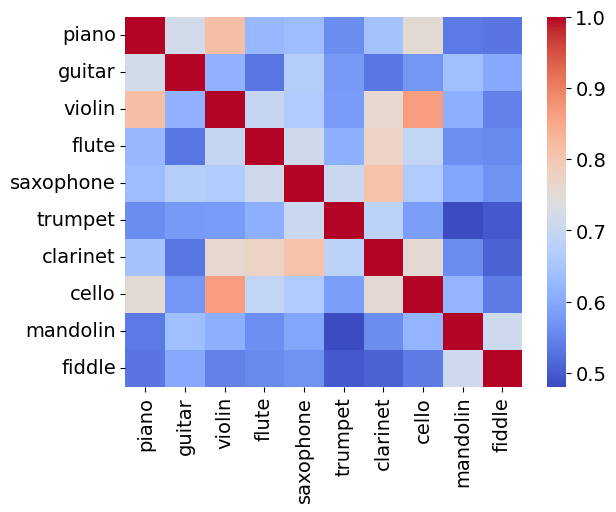

0.2516719003121432 1.0000000000000013


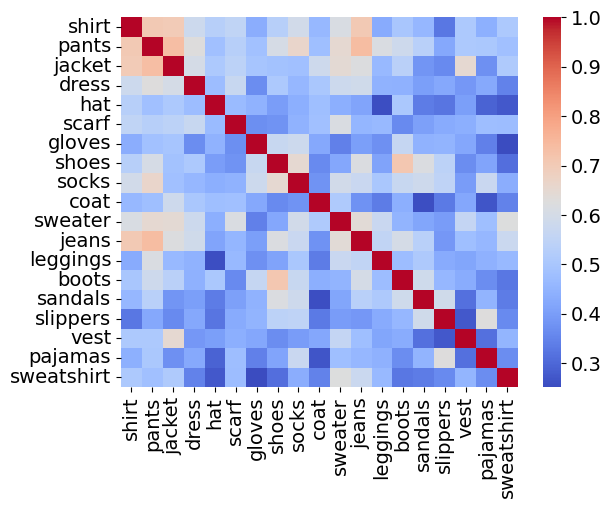

0.30346091160892197 1.000000000000001


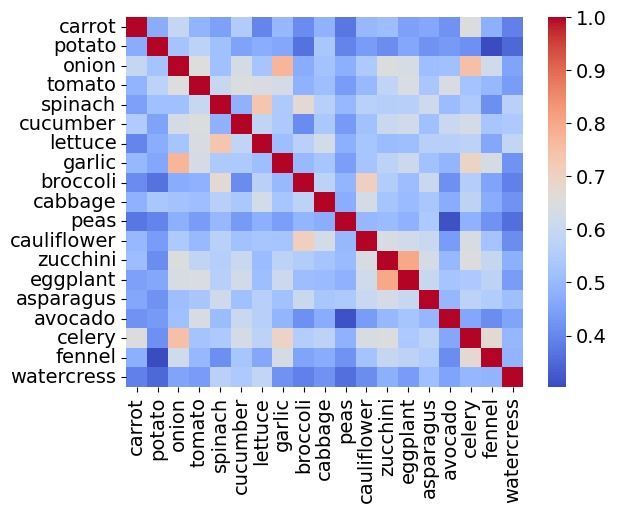

0.22757825763841977 1.0000000000000007


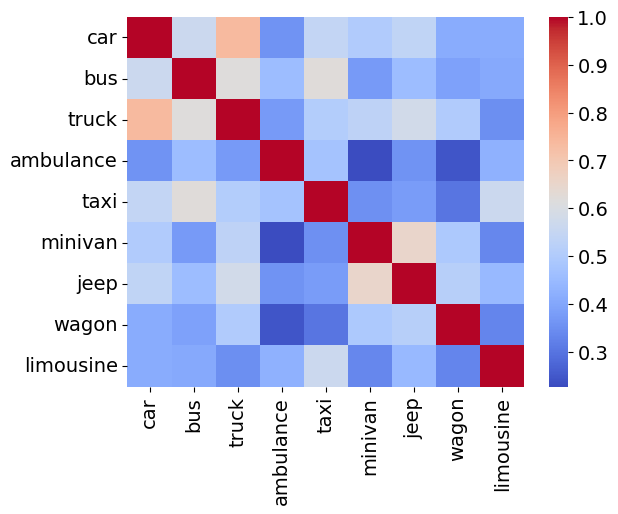

0.21870633251176946 1.0000000000000013


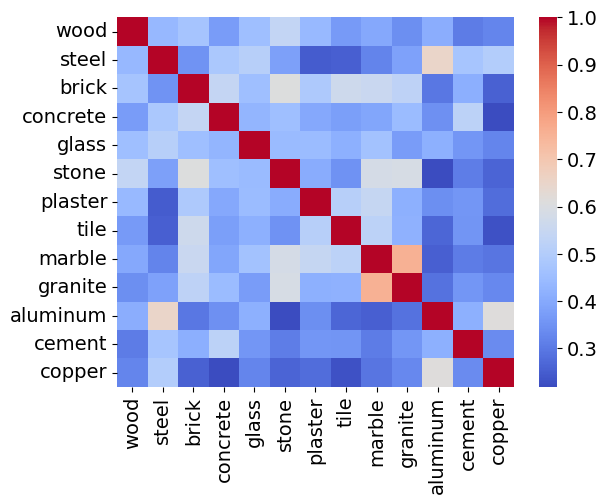

0.33653032843250696 1.0000000000000007


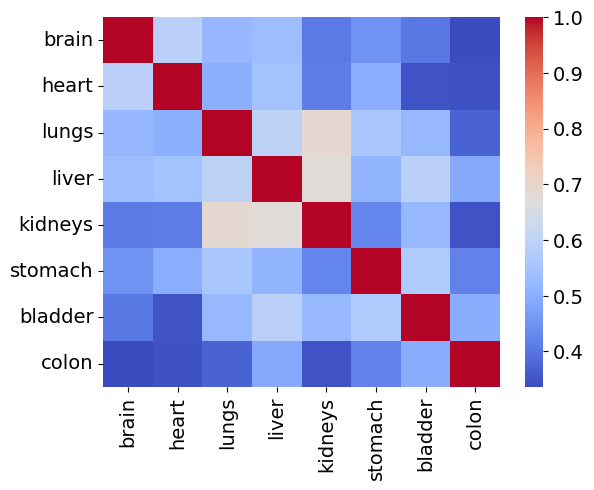

0.22673166236232054 1.000000000000001


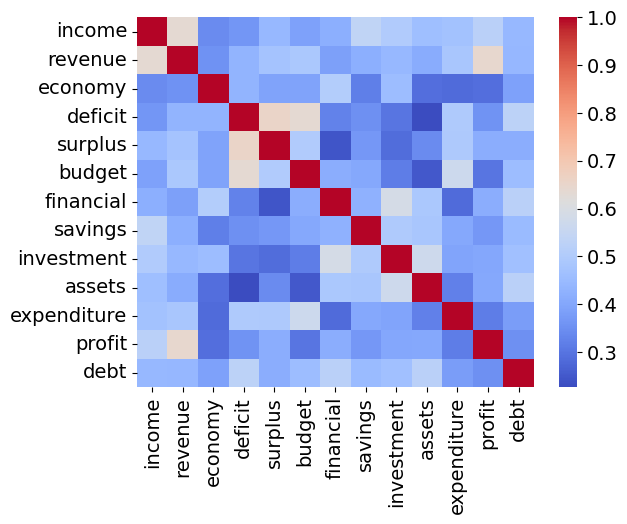

0.2584897726771708 1.0000000000000009


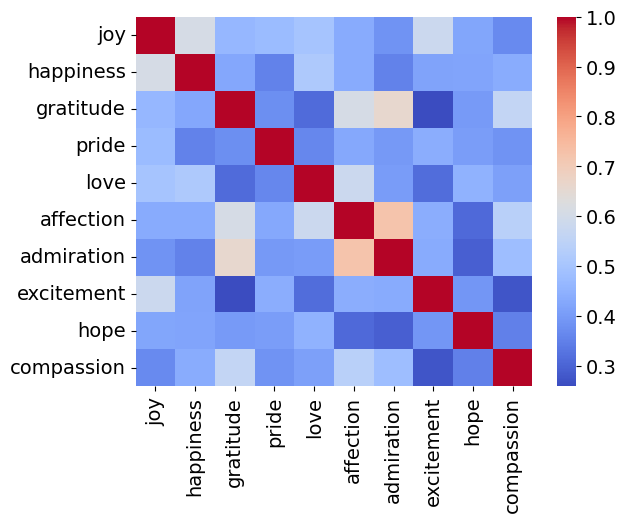

0.22669136520384842 1.0000000000000013


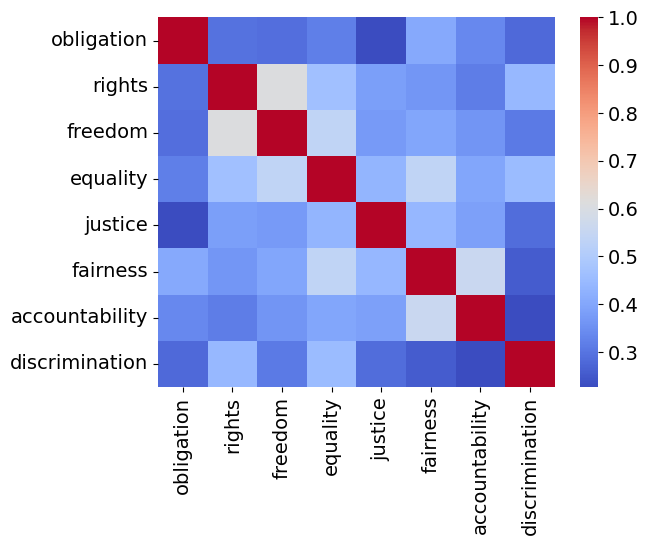

In [ ]:
for category, data in sem_categories.items():
    glove_embds = [get_embedding_for_word(word, df, 'glove_embeddings') for word in data['words']]
    glove_rsm = cosine_similarity(glove_embds)
    print(min(glove_rsm.flatten()), max(glove_rsm.flatten()))
    sns.heatmap(glove_rsm, xticklabels=data['words'], yticklabels=data['words'], cmap='coolwarm', cbar=True)
    plt.show()

<h5>For all categories</h5>

<Axes: >

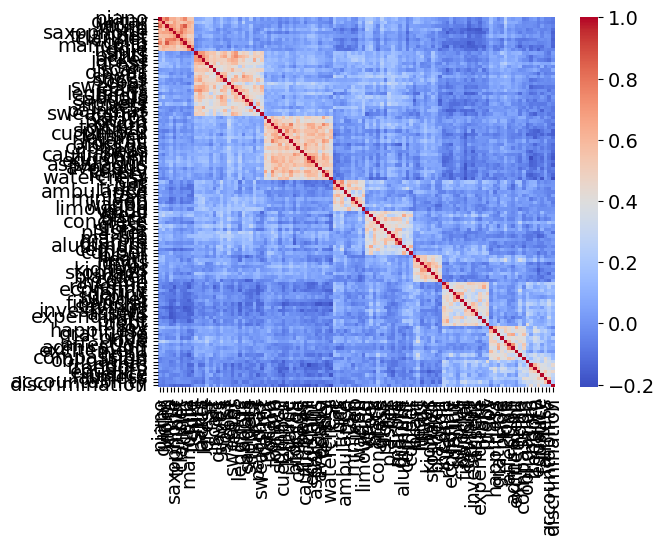

In [ ]:
word_list = [word for category in sem_categories.values() for word in category['words']]
glove_embds = [get_embedding_for_word(word, df, 'glove_embeddings') for word in word_list]
glove_rsm = cosine_similarity(glove_embds)
sns.heatmap(glove_rsm, xticklabels=word_list, yticklabels=word_list, cmap='coolwarm', cbar=True)

<h4>Check the phonetic similarity matrix for the found words to see whether they are phonetically different from one another within the same category</h4>

<Axes: >

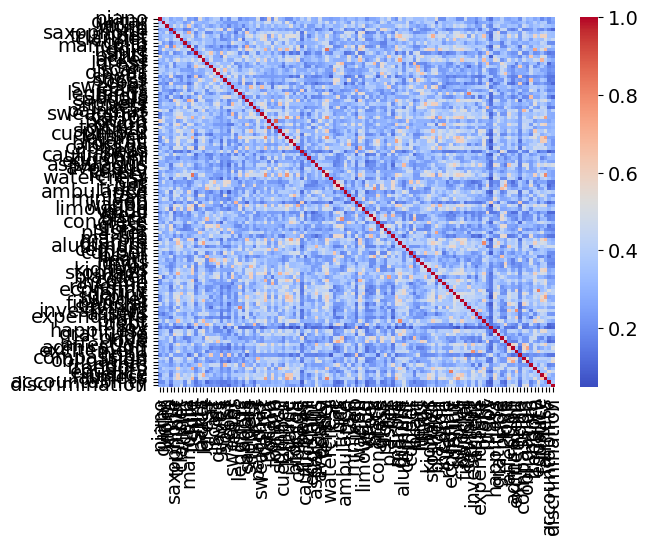

In [111]:
phon_sim_matrix = compute_phonetic_similarity_matrix(word_list, pronunc_df)
sns.heatmap(phon_sim_matrix, xticklabels=word_list, yticklabels=word_list, cmap='coolwarm', cbar=True)

<h4>Split into concrete and abstract categories</h4>

In [ ]:
sem_concrete_cats = {
    key: value for key, value in sem_categories.items() if value['scores']['avg_concreteness_score'] > 3.0
}
sem_abstract_cats = {
    key: value for key, value in sem_categories.items() if value['scores']['avg_concreteness_score'] <= 3.0
}

#### Perform analysis

In [ ]:
# combined set
sem_results_all = get_robust_clustering_results(df, sem_categories, 'sem')
with open(f'{data_path}/sem_all_cats_lda_pca_stable_results.pkl', 'wb') as f:
    pickle.dump(sem_results_all, f)

In [ ]:
# concrete categories
sem_results_conc = get_robust_clustering_results(df, sem_concrete_cats, 'sem')
with open(f'{data_path}/sem_conc_cats_lda_pca_stable_results.pkl', 'wb') as f:
    pickle.dump(sem_results_conc, f)

In [ ]:
# abstract categories
sem_results_abs = get_robust_clustering_results(df, sem_abstract_cats, 'sem')
with open(f'{data_path}/sem_abs_cats_lda_pca_stable_results.pkl', 'wb') as f:
    pickle.dump(sem_results_abs, f)

In [ ]:
#plot_reduced_results(sem_results_all, sem_categories, category_mapping, model_mapping)

<h2>Phonetic Clustering</h2>

In [ ]:
if COMPUTE_PHONETIC_GROUPS:
    filtered_df = df[df['words'].isin(pronunc_df['Item'])]
    if COMPUTE_PHONETIC_SIMILARITY:
        phon_sim = compute_phonetic_similarity_matrix(filtered_df['words'].values, pronunc_df)
        np.save(data_path + 'phon_sim.npy', phon_sim)
    else:
        phon_sim = np.load(data_path + 'phon_sim.npy')

    # get 90th percentile of phonetic similarity:
    phon_percentile = np.percentile(phon_sim, 90)

    # get phonetic groups
    limit = 10

    word_pool = list(filtered_df['words'].values)  # Initialize the word pool

    phon_groups = {}
    num_concrete = 0
    num_abstract = 0
    num_words_chosen = 0
    phonetic_dissimilarity_threshold = 0.4

    # Loop until both abstract and concrete categories have at least <limit> clusters
    while num_concrete < limit or num_abstract < limit:
        if len(word_pool) == 0:
            break  
        
        word = random.choice(word_pool)
        num_words_chosen += 1

        if num_words_chosen % 100 == 0:
            print(f"Chosen {num_words_chosen} words so far...")
        
        # 1. Get the top N similar words with a threshold
        similar_words = get_top_n_similar_words(word, filtered_df['words'], phon_sim, n=100, thresh=phon_percentile)

        # 2. Filter the similar words by semantic dissimilarity
        dissimilar_words, avg_sim = get_semantically_dissimilar_words(similar_words, filtered_df, n=100, similarity_threshold=0.1)

        # 3. Apply the concreteness or abstractness filter for both categories
        if num_abstract < limit:
            abstract_words, abstract_scores = filter_by_concreteness([word for word in dissimilar_words], conc_abs_df, pronunc_df, filter_type="abstract", low_threshold_percentile=25, high_threshold_percentile=75)
        if num_concrete < limit:
            concrete_words, concrete_scores = filter_by_concreteness([word for word in dissimilar_words], conc_abs_df, pronunc_df, filter_type="concrete", low_threshold_percentile=25, high_threshold_percentile=75)

        # If the abstract words category has at least 5 words, is unique, and is phonetically dissimilar, add it
        if (
            len(abstract_words) >= 5
            and all(w in word_pool for w in abstract_words)
            and num_abstract < limit
            and is_phonetically_different(abstract_words, phon_groups, phon_sim, threshold=phonetic_dissimilarity_threshold)
        ):
            cluster_name = f'abstract_{word}'
            print(f'abstract cluster number {num_abstract + 1} found: {cluster_name}, {abstract_words}')
            phon_groups[cluster_name] = {
                'words': abstract_words,
                'scores': abstract_scores
            }
            phon_groups[cluster_name]['scores']['average_sem_similarity'] = avg_sim
            # Remove the used words from word_pool
            word_pool = [w for w in word_pool if w not in abstract_words]
            num_abstract += 1

        # If the concrete words category has at least 5 words, is unique, and is phonetically dissimilar, add it
        if (
            len(concrete_words) >= 5
            and all(w in word_pool for w in concrete_words)
            and num_concrete < limit
            and is_phonetically_different(concrete_words, phon_groups, phon_sim, threshold=phonetic_dissimilarity_threshold)
        ):
            cluster_name = f'concrete_{word}'
            print(f'concrete cluster number {num_concrete + 1} found: {cluster_name}: {concrete_words}')
            phon_groups[cluster_name] = {
                'words': concrete_words,
                'scores': concrete_scores
            }
            phon_groups[cluster_name]['scores']['average_sem_similarity'] = avg_sim
            # Remove the used words from word_pool
            word_pool = [w for w in word_pool if w not in concrete_words]
            num_concrete += 1

        # Stop if both abstract and concrete clusters have 15 or more categories
        if num_concrete >= limit and num_abstract >= limit:
            break

    print(phon_groups)
    dict(sorted(phon_groups.items(), key=lambda item: item[1]['scores']['avg_concreteness_score'], reverse=True))
    with open(data_path + 'phonetic_groups.json', 'w') as json_file:
        json.dump(phon_groups, json_file)
    print(f"Number of words chosen: {num_words_chosen}")
    
else:
    with open(data_path + 'phonetic_groups.json', 'r') as json_file:
        phon_groups = json.load(json_file)
    

In [ ]:
phon_concrete_groups = {
    key: value for key, value in phon_groups.items() if 'conc' in key
}
phon_abstract_groups = {
    key: value for key, value in phon_groups.items() if 'abs' in key
}

In [ ]:
# combined set
phon_results_all = get_robust_clustering_results(df, phon_groups, 'phon')
with open(f'{data_path}/phon_all_groups_lda_pca_stable_results.pkl', 'wb') as f:
    pickle.dump(phon_results_all, f)

In [ ]:
# concrete groups
phon_results_conc = get_robust_clustering_results(df, phon_concrete_groups, 'phon')
with open(f'{data_path}/phon_conc_groups_lda_pca_stable_results.pkl', 'wb') as f:
    pickle.dump(phon_results_conc, f)

In [ ]:
# abstract groups
phon_results_abs = get_robust_clustering_results(df, phon_abstract_groups, 'phon')
with open(f'{data_path}/phon_abs_groups_lda_pca_stable_results.pkl', 'wb') as f:
    pickle.dump(phon_results_abs, f)

# Plot results

## Figure 2

In [ ]:
phon_all_aggr_lda = {
    'wav2vec2': {f'layer_{i}': () for i in range(12)},
    'fast_vgs_plus': {f'layer_{i}': () for i in range(12)},
}
phon_all_aggr_pca = {
    'wav2vec2': {f'layer_{i}': () for i in range(12)},
    'fast_vgs_plus': {f'layer_{i}': () for i in range(12)},
}
phon_all_aggr_all = {
    'wav2vec2': {f'layer_{i}': () for i in range(12)},
    'fast_vgs_plus': {f'layer_{i}': () for i in range(12)},
}

In [ ]:
for model, results in phon_results_all.items():
    print(f'######## model: {model} ########')
    print(results.keys())
    for layer, scores in results['all_dims'].items():
        #print(f'layer: {layer}, scores: {scores}')
        phon_all_aggr_all[internal_model_mapping[model]][layer] = mean_confidence_interval(scores)

In [ ]:
# all dimensions
for model, results in phon_results_all.items():
    print(f'######## model: {model} ########')
    print(results.keys())
    for layer, scores in results['all_dims'].items():
        phon_all_aggr_all[internal_model_mapping[model]][layer] = mean_confidence_interval(scores)

# LDA dimensions
for model, results in phon_results_all.items():
    print(f'######## model: {model} ########')
    print(results.keys())
    for layer, scores in results['lda'].items():
        phon_all_aggr_lda[internal_model_mapping[model]][layer] = mean_confidence_interval(scores)

# PCA dimensions
for model, results in phon_results_all.items():
    print(f'######## model: {model} ########')
    print(results.keys())
    for layer, scores in results['pca'].items():
        phon_all_aggr_pca[internal_model_mapping[model]][layer] = mean_confidence_interval(scores)



In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Plot for wav2vec2
w2v2_lda_vals = [val[0] for val in phon_all_aggr_lda['wav2vec2'].values()]
w2v2_lda_errs = [val[1] for val in phon_all_aggr_lda['wav2vec2'].values()]
ax.plot(w2v2_lda_vals, color='C0', marker='o', linestyle=':', label='wav2vec2', linewidth=2)
ax.fill_between(np.arange(len(w2v2_lda_vals)), np.array(w2v2_lda_vals)-np.array(w2v2_lda_errs), np.array(w2v2_lda_vals)+np.array(w2v2_lda_errs), alpha=0.2, color='C0')

w2v2_pca_vals = [val[0] for val in phon_all_aggr_pca['wav2vec2'].values()]
w2v2_pca_errs = [val[1] for val in phon_all_aggr_pca['wav2vec2'].values()]
ax.plot(w2v2_pca_vals, color='C0', marker='o', linestyle='--', label='wav2vec2')
ax.fill_between(np.arange(len(w2v2_pca_vals)), np.array(w2v2_pca_vals)-np.array(w2v2_pca_errs), np.array(w2v2_pca_vals)+np.array(w2v2_pca_errs), alpha=0.2, color='C0')

w2v2_all_vals = [val[0] for val in phon_all_aggr_all['wav2vec2'].values()]
w2v2_all_errs = [val[1] for val in phon_all_aggr_all['wav2vec2'].values()]
ax.plot(w2v2_all_vals, color='C0', marker='o', linestyle='-', label='wav2vec2')
ax.fill_between(np.arange(len(w2v2_all_vals)), np.array(w2v2_all_vals)-np.array(w2v2_all_errs), np.array(w2v2_all_vals)+np.array(w2v2_all_errs), alpha=0.2, color='C0')

# Plot for FaST-VGS+
fast_vgs_plus_lda_vals = [val[0] for val in phon_all_aggr_lda['fast_vgs_plus'].values()]
fast_vgs_plus_lda_errs = [val[1] for val in phon_all_aggr_lda['fast_vgs_plus'].values()]
ax.plot(fast_vgs_plus_lda_vals, color='C1', marker='s', linestyle=':', label='FaST-VGS+', linewidth=2)
ax.fill_between(np.arange(len(fast_vgs_plus_lda_vals)), np.array(fast_vgs_plus_lda_vals)-np.array(fast_vgs_plus_lda_errs), np.array(fast_vgs_plus_lda_vals)+np.array(fast_vgs_plus_lda_errs), alpha=0.2, color='C1')

fast_vgs_plus_pca_vals = [val[0] for val in phon_all_aggr_pca['fast_vgs_plus'].values()]
fast_vgs_plus_pca_errs = [val[1] for val in phon_all_aggr_pca['fast_vgs_plus'].values()]
ax.plot(fast_vgs_plus_pca_vals, color='C1', marker='s', linestyle='--', label='FaST-VGS+')
ax.fill_between(np.arange(len(fast_vgs_plus_pca_vals)), np.array(fast_vgs_plus_pca_vals)-np.array(fast_vgs_plus_pca_errs), np.array(fast_vgs_plus_pca_vals)+np.array(fast_vgs_plus_pca_errs), alpha=0.2, color='C1')

fast_vgs_plus_all_vals = [val[0] for val in phon_all_aggr_all['fast_vgs_plus'].values()]
fast_vgs_plus_all_errs = [val[1] for val in phon_all_aggr_all['fast_vgs_plus'].values()]
ax.plot(fast_vgs_plus_all_vals, color='C1', marker='s', linestyle='-', label='FaST-VGS+')
ax.fill_between(np.arange(len(fast_vgs_plus_all_vals)), np.array(fast_vgs_plus_all_vals)-np.array(fast_vgs_plus_all_errs), np.array(fast_vgs_plus_all_vals)+np.array(fast_vgs_plus_all_errs), alpha=0.2, color='C1')

handles = [
    mlines.Line2D([], [], color='black', linestyle=':', label='LDA Dimensions', linewidth=2),
    mlines.Line2D([], [], color='black', linestyle='--', label='PCA Dimensions'),
    mlines.Line2D([], [], color='black', linestyle='-', label='All Dimensions'),
    mlines.Line2D([], [], color='C0', marker='o', label='wav2vec2'),
    mlines.Line2D([], [], color='C1', marker='s', label='FaST-VGS+'),
]
ax.set_xticks([0, 5, 10])
ax.set_xlabel('Layer Index')
ax.set_ylabel('Silhouette Coeff.')
ax.set_yticks([-0.3, -0.1, 0.1, 0.3])
plt.tight_layout()
ax.legend(handles=handles, loc='center', ncol=2, fontsize=12, bbox_to_anchor=(0.3, 0.2))
plt.savefig(f'{figure_path}phon_all_pca_lda_small.pdf', bbox_inches='tight')
plt.show()

## Figure 3

In [ ]:
sem_all_aggr = {
    'wav2vec2': {f'layer_{i}': () for i in range(12)},
    'fast_vgs_plus': {f'layer_{i}': () for i in range(12)},
    'reg_bert': {f'layer_{i}': () for i in range(12)},
    'vg_bert': {f'layer_{i}': () for i in range(12)},
    'glove': ()
}

In [ ]:
for model, results in sem_results_all.items():
    print(f'######## model: {model} ########')
    print(results.keys())
    if model == 'glove_embeddings':
        sem_all_aggr[internal_model_mapping[model]] = mean_confidence_interval(results['lda'])
    else:
        for layer, scores in results['lda'].items():
            sem_all_aggr[internal_model_mapping[model]][layer] = mean_confidence_interval(scores)

In [ ]:
sem_SLE_TLE = {
    "FINAL_sem_lda_SLE_TLE": {
        "left": sem_all_aggr,
        "right": sem_all_aggr,
        'models': [['wav2vec2', 'fast_vgs_plus'], ['reg_bert', 'vg_bert']],
        'num_results': [1, 1],
        'line_styles': ['-', ['--', '-.']],
        'y_ticks': [[0.1, 0.3, 0.5, 0.7], [0.1, 0.3, 0.5, 0.7]],
        'model_mappings': model_mappings,
        'color_mappings': color_mappings,
        'marker_mappings': marker_mappings,
        'bbox_to_anchor': [(0.5, 0.45), (0.56, 0.425)],
    }
}

In [ ]:
plt.rcParams.update({'font.size': 14})
figsize = (8, 3)

for pair, meta in sem_SLE_TLE.items():
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axes = axs.flatten()
    
    bbox_to_anchor = meta['bbox_to_anchor']
    plot_title = f'{pair}'
    spec_y_ticks = meta['y_ticks']
    for i, (loc, ax, y_ticks) in enumerate(zip(('left', 'right'), axes, spec_y_ticks)):
        results = meta[loc]
        for model in meta['models'][i]:
            scores = results[model]
            means = np.array([score[0] for score in scores.values()])
            errors = np.array([score[1] for score in scores.values()])
            ax.plot(means, label=meta['model_mappings'][model], color=meta['color_mappings'][model], marker=meta['marker_mappings'][model])
            ax.fill_between(np.arange(len(means)), means-errors, means+errors, alpha=0.2, color=meta['color_mappings'][model])
        ax.set_xlabel('Layer Index')
        ax.set_xticks([0, 5, 10])
        ax.set_ylabel('Silhouette Coeff.')
        ax.set_yticks(y_ticks)
        ax.plot(np.arange(0, 12), [sem_all_aggr['glove'][0]] * 12, color='black', linestyle='--', label='GloVe')
        ax.fill_between(np.arange(0, 12), np.array([sem_all_aggr['glove'][0]]*12) - np.array([sem_all_aggr['glove'][1]]*12), np.array([sem_all_aggr['glove'][0]]*12) + np.array([sem_all_aggr['glove'][1]]*12), alpha=0.2, color='black')
    plt.tight_layout()
    for ax, bbox_to_anchor in zip(axes, meta['bbox_to_anchor']):
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, bbox_to_anchor=bbox_to_anchor, ncol=1, fontsize=11)
    plt.savefig(f'{figure_path}{plot_title}_glove.pdf', bbox_inches='tight')
    plt.show()